# Model

In [714]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2output = nn.Linear(hidden_size, output_size)
        self.NonlinearFunc = nn.Tanh()
    
    def forward(self, input, hidden):
        a = 0.5
        hidden = self.NonlinearFunc((1-a)*hidden + a*self.input2hidden(input) + a*self.hidden2hidden(nn.functional.relu(hidden)))
        output = self.NonlinearFunc(self.hidden2output(hidden))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

# Task 1 : Perceptual Decision Making

## Task 1 : Dataset

In [715]:
def decision_making_dataset(DC_value1, DC_value2, Input_size, Noise_amplitude, N, DC_val_opt):
    
    if DC_val_opt==1:
        Inp1 = DC_value1 + Noise_amplitude*(torch.rand(1,Input_size,N)-0.5)
        Inp2 = DC_value2 + Noise_amplitude*(torch.rand(1,Input_size,N)-0.5)
        Inp = torch.cat((Inp1,Inp2),0)
        Output = torch.zeros(1,2,N)
        if DC_value2 > DC_value1 :
            Output[0,1,:]=1
        else:
            Output[0,0,:]=1
    else:
        Inp1 = Noise_amplitude*(torch.rand(1,Input_size,N)-0.5)
        Inp2 = Noise_amplitude*(torch.rand(1,Input_size,N)-0.5)
        for j in range(N):
            Inp1[0,:,j] = numpy.random.randint(1,10) + Inp1[0,:,j]
            Inp2[0,:,j] = numpy.random.randint(1,10) + Inp2[0,:,j]
            
        Inp = torch.cat((Inp1,Inp2),0)
        Output = torch.zeros(1,2,N)
        for i in range(N):
            if torch.mean(Inp1[0,:,i]) < torch.mean(Inp2[0,:,i]) :
                Output[0,1,i]=1
            else:
                Output[0,0,i]=1
    Output = Output.squeeze()
    return Inp,Output

## Task 1 : Dataset Check

torch.Size([2, 1, 8])


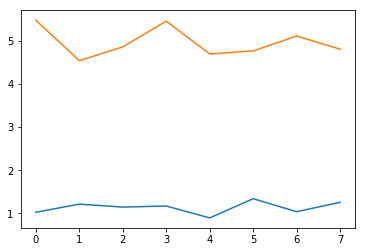

tensor([[[1.0263, 1.2158, 1.1472, 1.1718, 0.8962, 1.3413, 1.0403, 1.2571]],

        [[5.4734, 4.5382, 4.8568, 5.4539, 4.6913, 4.7640, 5.1076, 4.8027]]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])


In [716]:
import numpy
import matplotlib.pylab as plt
X,Y = decision_making_dataset(DC_value1=1, DC_value2=5, Input_size=1, Noise_amplitude=1, N=8, DC_val_opt=1)
print(X.size())
plt.figure
plt.plot(X[0,0,:].numpy())
plt.plot(X[1,0,:].numpy())
plt.show()
print(X)
print(Y)

## Task 1 : First Implementation

In [721]:
def predictor(output,N):
    out = torch.zeros(2,N)
    for i in range(N):
        if (output[0,i]>output[1,i]):
            out[0,i] = 1
            out[1,i] = 0
        else:
            out[0,i] = 0
            out[1,i] = 1
    return out
    
    return (output>0.5).double()

def pdm_task1 (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100):

    rnn = RNN(input_size=2, hidden_size=hidden_size, output_size=2)
    
    L = sequence_length
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
#     input, target = parity_generator(N,L)
    input, target = decision_making_dataset(DC_value1=1, DC_value2=1.1, Input_size=L, Noise_amplitude=0.2, N=N, DC_val_opt=0)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        #optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((2, N)))

        for i in range (N):
            hidden = rnn.init_hidden()
            
            for j in range (L):
                output, hidden = rnn.forward(input[:,j,i], hidden)
            loss = criterion(output.float(), target[:,i].unsqueeze(0))
            if(epochs == number_of_epochs-1):
                OUT[:,i] = output;
            loss.backward()
            if (N%batch_size==0):
                optimizer.step()
                
                for j in range (hidden_size):
                    list(rnn.hidden2hidden.parameters())[0].data[j, j].data.copy_(torch.tensor(0))
                    for i in range (hidden_size):
                        sign = 1
                        if j >= hidden_size * 4 / 5:
                            sign = -1
                        if (list(rnn.hidden2hidden.parameters())[0].data[i, j].item() * sign < 0):
                            list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))

                
                rnn.zero_grad()        
        
        if (epochs%20==19):
            print('epoch=',epochs+1, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()

    print('true percentage on train set = ',100*torch.sum(predictor(OUT,N)[0,:]==target[0,:]).item()/N)

    plt.figure
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    s = (rnn.hidden2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('Weight Matrix')    
    plt.show()
    
    s = (rnn.input2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('input-to-hidden Matrix')    
    plt.show()
    
    s = (rnn.hidden2output.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('hidden-to-output Matrix')    
    plt.show()


    number_of_tests = 100
    
    true_percentage = np.zeros(10)
    
    for k in range(10):
        delta = 0.2*(k+1)
        test_input, test_target = decision_making_dataset(DC_value1=1, DC_value2=1+delta, Input_size=L, Noise_amplitude=1, N = number_of_tests, DC_val_opt=1)

        test_OUT = torch.tensor(np.zeros((2, number_of_tests)))

        hidden = rnn.init_hidden()
        for test in range (number_of_tests):
            hidden = rnn.init_hidden()
            for i in range (L):
                rnn.zero_grad()
                output, hidden = rnn(test_input[:,i,test], hidden)
                if(test == number_of_tests-1):
                    print(output)
            test_OUT[:,test] = output

        true_percentage[k] = 100*torch.sum(predictor(test_OUT,number_of_tests)[0,:]==test_target[0,:]).item()/number_of_tests
        print('true percentage on test set = ',true_percentage[k])
        
    plt.figure
    plt.plot(true_percentage)
    plt.title('true percentage for different coherences')
    plt.show()
        
    return true_percentage


epoch= 20 , loss= 0.19599877297878265
epoch= 40 , loss= 0.19803130626678467
epoch= 60 , loss= 0.1956087052822113
epoch= 80 , loss= 0.19110260903835297
epoch= 100 , loss= 0.18894486129283905
true percentage on train set =  94.0


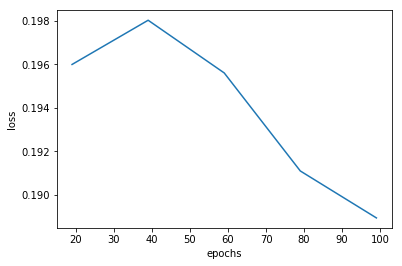

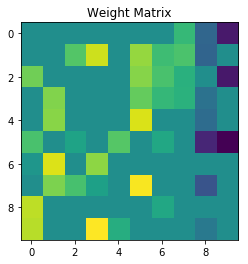

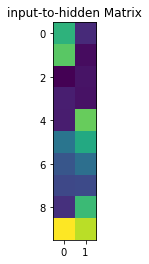

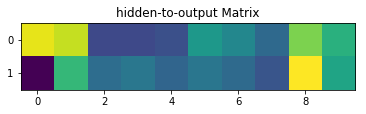

tensor([[0.6057, 0.2402]], grad_fn=<TanhBackward>)
true percentage on test set =  62.0
tensor([[0.0116, 0.7692]], grad_fn=<TanhBackward>)
true percentage on test set =  83.0
tensor([[0.0738, 0.7510]], grad_fn=<TanhBackward>)
true percentage on test set =  82.0
tensor([[-0.0289,  0.7549]], grad_fn=<TanhBackward>)
true percentage on test set =  99.0
tensor([[-0.0589,  0.9107]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.0543,  0.9167]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.0356,  0.8942]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.1520,  0.9767]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.1024,  0.9456]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.0951,  0.9816]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0


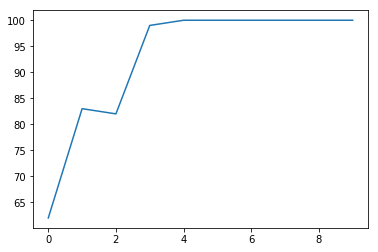

epoch= 20 , loss= 0.3998132050037384
epoch= 40 , loss= 0.45064577460289
epoch= 60 , loss= 0.36452698707580566
epoch= 80 , loss= 0.3828459084033966
epoch= 100 , loss= 0.41778039932250977
true percentage on train set =  94.0


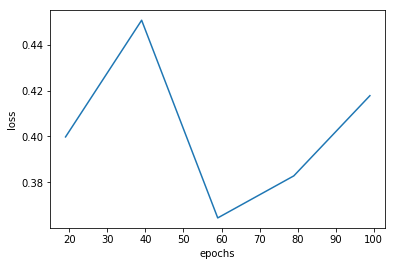

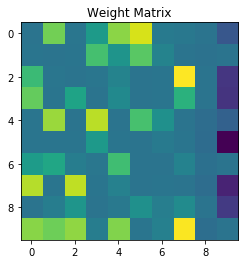

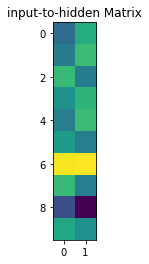

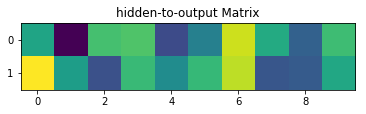

tensor([[0.3319, 0.9328]], grad_fn=<TanhBackward>)
tensor([[0.0629, 0.9619]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.2382, 0.9516]], grad_fn=<TanhBackward>)
tensor([[-0.0267,  0.9717]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.1493, 0.9638]], grad_fn=<TanhBackward>)
tensor([[-0.1295,  0.9926]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.3268, 0.9298]], grad_fn=<TanhBackward>)
tensor([[-0.0165,  0.9888]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.1370, 0.9648]], grad_fn=<TanhBackward>)
tensor([[-0.0415,  0.9844]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.1298, 0.9623]], grad_fn=<TanhBackward>)
tensor([[-0.0416,  0.9947]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.3117, 0.9329]], grad_fn=<TanhBackward>)
tensor([[-0.0247,  0.9925]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[-0.039

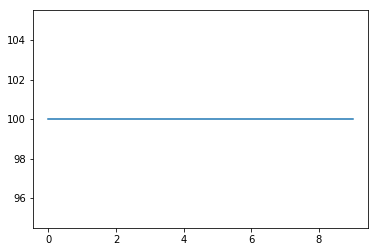

epoch= 20 , loss= 0.002066811313852668
epoch= 40 , loss= 0.0021990081295371056
epoch= 60 , loss= 0.001832256792113185
epoch= 80 , loss= 0.0032352269627153873
epoch= 100 , loss= 0.0017539099790155888
true percentage on train set =  94.0


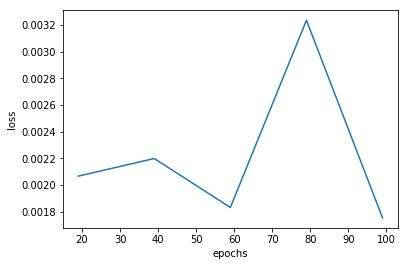

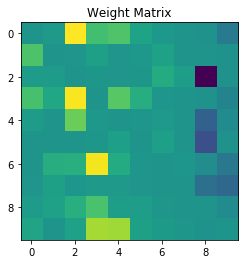

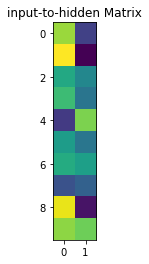

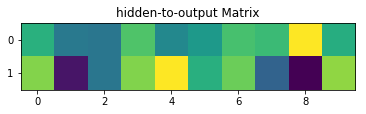

tensor([[0.3651, 0.4774]], grad_fn=<TanhBackward>)
tensor([[0.3399, 0.2186]], grad_fn=<TanhBackward>)
tensor([[0.6804, 0.1014]], grad_fn=<TanhBackward>)
true percentage on test set =  23.0
tensor([[0.3232, 0.7439]], grad_fn=<TanhBackward>)
tensor([[0.1830, 0.7204]], grad_fn=<TanhBackward>)
tensor([[0.3226, 0.6432]], grad_fn=<TanhBackward>)
true percentage on test set =  69.0
tensor([[0.2839, 0.8569]], grad_fn=<TanhBackward>)
tensor([[0.1556, 0.8897]], grad_fn=<TanhBackward>)
tensor([[0.2187, 0.8171]], grad_fn=<TanhBackward>)
true percentage on test set =  96.0
tensor([[0.2198, 0.9369]], grad_fn=<TanhBackward>)
tensor([[0.1491, 0.9664]], grad_fn=<TanhBackward>)
tensor([[0.0197, 0.9738]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.2306, 0.9272]], grad_fn=<TanhBackward>)
tensor([[0.1874, 0.9111]], grad_fn=<TanhBackward>)
tensor([[0.1740, 0.9121]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.1591, 0.9736]], grad_fn=<TanhBackward>)
te

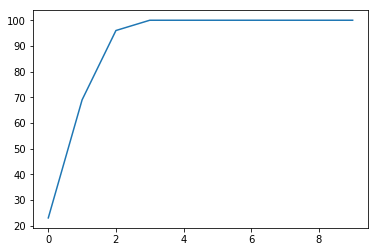

epoch= 20 , loss= 0.012982538901269436
epoch= 40 , loss= 0.004416954703629017
epoch= 60 , loss= 0.004112578928470612
epoch= 80 , loss= 0.005635224282741547
epoch= 100 , loss= 0.0061851078644394875
true percentage on train set =  96.0


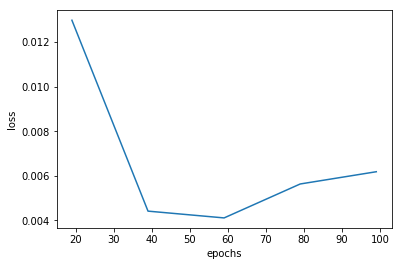

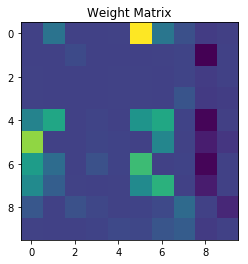

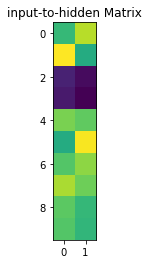

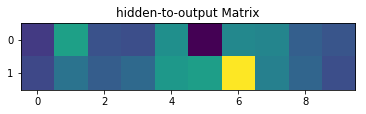

tensor([[0.3549, 0.6065]], grad_fn=<TanhBackward>)
tensor([[0.1122, 0.7289]], grad_fn=<TanhBackward>)
tensor([[-0.0183,  0.9492]], grad_fn=<TanhBackward>)
tensor([[-0.0125,  0.9925]], grad_fn=<TanhBackward>)
true percentage on test set =  93.0
tensor([[0.7393, 0.5042]], grad_fn=<TanhBackward>)
tensor([[0.6558, 0.5179]], grad_fn=<TanhBackward>)
tensor([[0.6115, 0.5168]], grad_fn=<TanhBackward>)
tensor([[0.5416, 0.6327]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.6200, 0.5316]], grad_fn=<TanhBackward>)
tensor([[0.4467, 0.5891]], grad_fn=<TanhBackward>)
tensor([[0.3222, 0.7499]], grad_fn=<TanhBackward>)
tensor([[0.1011, 0.9260]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.4383, 0.6148]], grad_fn=<TanhBackward>)
tensor([[0.1034, 0.7379]], grad_fn=<TanhBackward>)
tensor([[0.0091, 0.9496]], grad_fn=<TanhBackward>)
tensor([[0.0252, 0.9926]], grad_fn=<TanhBackward>)
true percentage on test set =  100.0
tensor([[0.2590, 0.6549]], grad_f

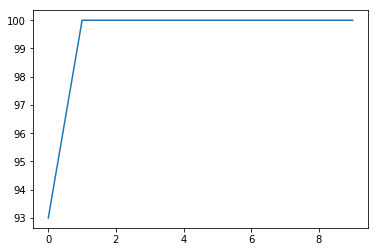

epoch= 20 , loss= 0.0009405830642208457
epoch= 40 , loss= 7.768625800963491e-05
epoch= 60 , loss= 0.002461216179654002
epoch= 80 , loss= 2.8139460482634604e-05
epoch= 100 , loss= 0.00044022410293109715
true percentage on train set =  96.0


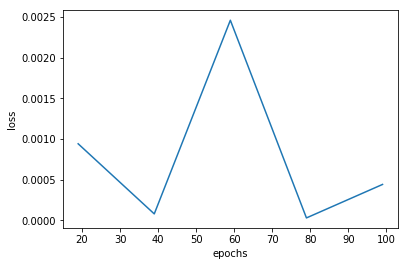

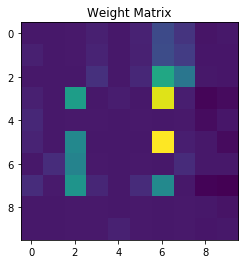

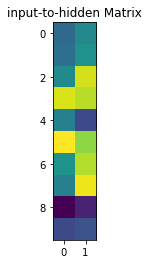

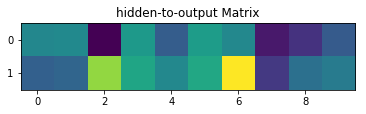

tensor([[0.9086, 0.0433]], grad_fn=<TanhBackward>)
tensor([[0.9364, 0.0085]], grad_fn=<TanhBackward>)
tensor([[0.8653, 0.0529]], grad_fn=<TanhBackward>)
tensor([[0.7628, 0.2367]], grad_fn=<TanhBackward>)
tensor([[0.4748, 0.4424]], grad_fn=<TanhBackward>)
true percentage on test set =  61.0
tensor([[0.9455, 0.0492]], grad_fn=<TanhBackward>)
tensor([[0.7439, 0.1571]], grad_fn=<TanhBackward>)
tensor([[0.6443, 0.3969]], grad_fn=<TanhBackward>)
tensor([[0.4555, 0.5704]], grad_fn=<TanhBackward>)
tensor([[0.2825, 0.7835]], grad_fn=<TanhBackward>)
true percentage on test set =  91.0
tensor([[0.7634, 0.2835]], grad_fn=<TanhBackward>)
tensor([[0.4712, 0.5775]], grad_fn=<TanhBackward>)
tensor([[0.3276, 0.7795]], grad_fn=<TanhBackward>)
tensor([[0.2129, 0.8972]], grad_fn=<TanhBackward>)
tensor([[0.1632, 0.9222]], grad_fn=<TanhBackward>)
true percentage on test set =  98.0
tensor([[0.9404, 0.1235]], grad_fn=<TanhBackward>)
tensor([[0.8113, 0.0886]], grad_fn=<TanhBackward>)
tensor([[0.4904, 0.5269]]

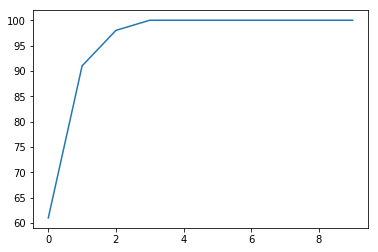

In [724]:
true_percentage = np.zeros([5,10])
for i in range (5):
    true_percentage[i,:] = pdm_task1 (learning_rate=0.05, hidden_size=10, batch_size=50, number_of_epochs=100, sequence_length=i+1, dataset_size = 100)

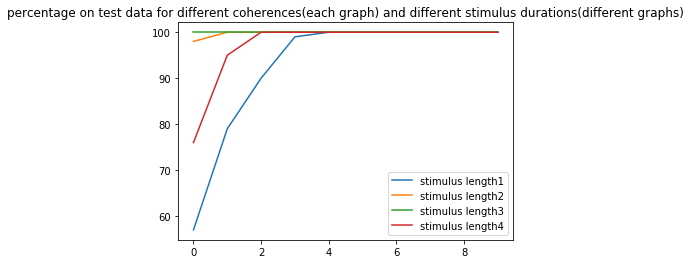

In [723]:
plt.figure
for i in range (1,5):
    plt.plot(true_percentage[i,:],label = 'stimulus length'+str(i))
plt.title('percentage on test data for different coherences(each graph) and different stimulus durations(different graphs)')
plt.legend()
plt.show()
    

## Task 1 : Second Implementation

In [698]:
def predictor(output,N):
    out = torch.zeros(2,N)
    for i in range(N):
        if (output[0,i]>output[1,i]):
            out[0,i] = 1
            out[1,i] = 0
        else:
            out[0,i] = 0
            out[1,i] = 1
    return out

    return (output>0.5).double()

def pdm_task2 (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100):

    rnn = RNN(input_size=2, hidden_size=hidden_size, output_size=2)
    
    L = sequence_length
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
#     input, target = parity_generator(N,L)
    input, target = decision_making_dataset(DC_value1=1, DC_value2=1.1, Input_size=L, Noise_amplitude=0.2, N=N, DC_val_opt=0)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        #optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((2, N)))
        
        temp_out = torch.zeros(2,L)
        for i in range (N):
            hidden = rnn.init_hidden()
            
            for j in range (L):
                output, hidden = rnn.forward(input[:,j,i], hidden)
                if (output[0,0]>output[0,1]):
                    temp_out[0,j] = 1
                    temp_out[1,j] = 0
                else:
                c    temp_out[0,j] = 0
                    temp_out[1,j] = 1
#                 temp_out[:,j] = predictor(output,1)
                if (j>1 and temp_out[0,j] == temp_out[0,j-1] and temp_out[0,j] == temp_out[0,j-2]):
                    break
            loss = criterion(output.float(), target[:,i].unsqueeze(0))
            if(epochs == number_of_epochs-1):
                OUT[:,i] = output;
#                 print(output.data.numpy())
            loss.backward()
            if (N%batch_size==0):
                optimizer.step()
                
                for j in range (hidden_size):
                    list(rnn.hidden2hidden.parameters())[0].data[j, j].data.copy_(torch.tensor(0))
                    for i in range (hidden_size):
                        sign = 1
                        if j >= hidden_size * 4 / 5:
                            sign = -1
                        if (list(rnn.hidden2hidden.parameters())[0].data[i, j].item() * sign < 0):
                            list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))

                
                rnn.zero_grad()        
        
        if (epochs%20==19):
            print('epoch=',epochs+1, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()
    print(predictor(OUT,N))
    print(target)
    print('true percentage on train set = ',100*torch.sum(predictor(OUT,N)[0,:]==target[0,:]).item()/N)

    plt.figure
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    s = (rnn.hidden2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('Weight Matrix')    
    plt.show()
    
    s = (rnn.input2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('input-to-hidden Matrix')    
    plt.show()
    
    s = (rnn.hidden2output.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('hidden-to-output Matrix')    
    plt.show()


    number_of_tests = 100
    
    test_OUT = torch.tensor(np.zeros((2, number_of_tests)))
    
    reaction_time = np.zeros(10)
    true_percentage = np.zeros(10)
    
    for k in range(10):
        test_input, test_target = decision_making_dataset(DC_value1=1, DC_value2=1.5+0.5*k, Input_size=L, Noise_amplitude=2, N = number_of_tests, DC_val_opt=1)
        rt = np.zeros(number_of_tests)
        hidden = rnn.init_hidden()
        for test in range (number_of_tests):
            hidden = rnn.init_hidden()
            for i in range (L):
                rnn.zero_grad()
                output, hidden = rnn(test_input[:,i,test], hidden)
                if (output[0,0]>output[0,1]):
                        temp_out[0,i] = 1
                        temp_out[1,i] = 0
                else:
                    temp_out[0,i] = 0
                    temp_out[1,i] = 1
                if (i>1 and temp_out[0,i] == temp_out[0,i-1] and temp_out[0,i] == temp_out[0,i-2]):
                    rt[test] = i
                    break

            test_OUT[:,test] = output
            reaction_time[k] = np.mean(rt)
            true_percentage[k] = 100*torch.sum(predictor(test_OUT,number_of_tests)[0,:]==test_target[0,:]).item()/number_of_tests

    plt.figure
    plt.plot(reaction_time)
    plt.title('reaction_time for different values of coherence')
    plt.show()
    
    plt.figure
    plt.plot(true_percentage)
    plt.title('true percentage on test data for different values of coherence')
    plt.show()


        
        
    return


epoch= 20 , loss= 0.0032902539242058992
epoch= 40 , loss= 0.0063542695716023445
epoch= 60 , loss= 0.008894841186702251
epoch= 80 , loss= 0.007034508977085352
epoch= 100 , loss= 0.0008454361814074218
tensor([[0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
         0., 1., 1., 0., 0., 1., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
         1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
         1., 1., 0., 0

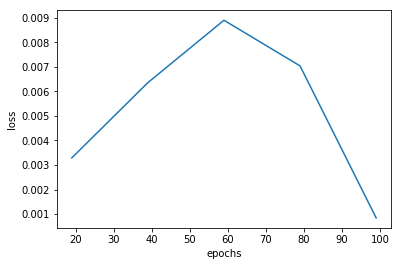

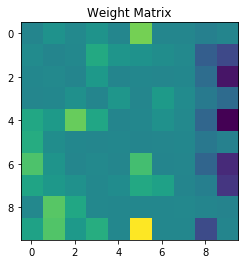

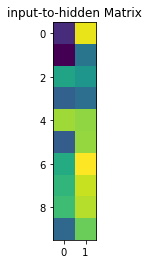

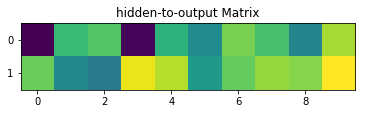

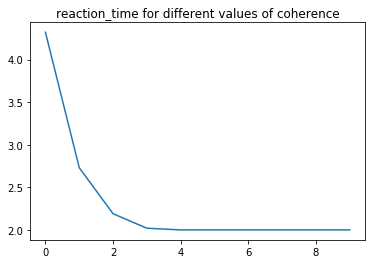

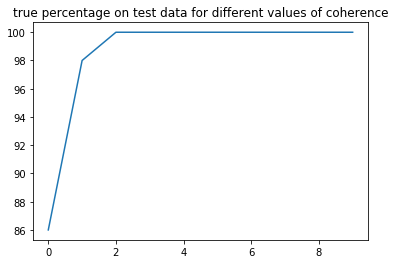

In [699]:
pdm_task2 (learning_rate=0.05, hidden_size=10, batch_size=50, number_of_epochs=100, sequence_length=20, dataset_size = 100)

## Task 1 : Third Implementation

In [725]:
def predictor(output,N):
    out = torch.zeros(2,N)
    for i in range(N):
        if (output[0,i]>output[1,i]):
            out[0,i] = 1
            out[1,i] = 0
        else:
            out[0,i] = 0
            out[1,i] = 1
    return out

    return (output>0.5).double()

def pdm_task3 (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100):

    rnn = RNN(input_size=2, hidden_size=hidden_size, output_size=2)
    
    L = sequence_length
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
#     input, target = parity_generator(N,L)
    input, target = decision_making_dataset(DC_value1=1, DC_value2=1.1, Input_size=L, Noise_amplitude=0.2, N=N, DC_val_opt=0)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        #optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((2, N)))
        
        temp_out = torch.zeros(2,L)
        for i in range (N):
            hidden = rnn.init_hidden()
            
            for j in range (L):
                output, hidden = rnn.forward(input[:,j,i], hidden)
                if (output[0,0]>output[0,1]):
                    temp_out[0,j] = 1
                    temp_out[1,j] = 0
                else:
                    temp_out[0,j] = 0
                    temp_out[1,j] = 1
#                 temp_out[:,j] = predictor(output,1)
                if (j>1 and temp_out[0,j] == temp_out[0,j-1] and temp_out[0,j] == temp_out[0,j-2]):
                    break
            loss = criterion(output.float(), target[:,i].unsqueeze(0))
            if(epochs == number_of_epochs-1):
                OUT[:,i] = output;
#                 print(output.data.numpy())
            loss.backward()
            if (N%batch_size==0):
                optimizer.step()
                
                for j in range (hidden_size):
                    list(rnn.hidden2hidden.parameters())[0].data[j, j].data.copy_(torch.tensor(0))
                    for i in range (hidden_size):
                        sign = 1
                        if j >= hidden_size * 4 / 5:
                            sign = -1
                        if (list(rnn.hidden2hidden.parameters())[0].data[i, j].item() * sign < 0):
                            list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))
                            
                for i in range (int(hidden_size*2/5),int(hidden_size*4/5)):
                    for j in range (int(hidden_size*2/5)):
                        list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))
                        
                for i in range (int(hidden_size*2/5),int(hidden_size*4/5)):
                    for j in range (int(hidden_size*2/5)):
                        list(rnn.hidden2hidden.parameters())[0].data[j, i].data.copy_(torch.tensor(0))
                        
                for i in range (int(hidden_size*2/5),int(hidden_size*4/5)):
                    list(rnn.input2hidden.parameters())[0].data[i, 0].data.copy_(torch.tensor(0))
                    
                for i in range (int(hidden_size*2/5)):
                    list(rnn.input2hidden.parameters())[0].data[i, 1].data.copy_(torch.tensor(0))
                    
                for i in range (int(hidden_size*2/5),int(hidden_size*4/5)):
                    list(rnn.hidden2output.parameters())[0].data[0,i].data.copy_(torch.tensor(0))
                    
                for i in range (int(hidden_size*2/5)):
                    list(rnn.hidden2output.parameters())[0].data[1,i].data.copy_(torch.tensor(0))
                
                for i in range (int(hidden_size*4/5),hidden_size):
                    list(rnn.input2hidden.parameters())[0].data[i, 0].data.copy_(torch.tensor(0))
                    list(rnn.input2hidden.parameters())[0].data[i, 1].data.copy_(torch.tensor(0))
                    list(rnn.hidden2output.parameters())[0].data[0, i].data.copy_(torch.tensor(0))
                    list(rnn.hidden2output.parameters())[0].data[1, i].data.copy_(torch.tensor(0))


                
                rnn.zero_grad()        
        
        if (epochs%20==19):
            print('epoch=',epochs+1, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()
    print(predictor(OUT,N))
    print(target)
    print('true percentage on train set = ',100*torch.sum(predictor(OUT,N)[0,:]==target[0,:]).item()/N)

    plt.figure
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    s = (rnn.hidden2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('Weight Matrix')    
    plt.show()
    
    s = (rnn.input2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('input-to-hidden Matrix')    
    plt.show()
    
    s = (rnn.hidden2output.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('hidden-to-output Matrix')    
    plt.show()


    number_of_tests = 100
    
    test_OUT = torch.tensor(np.zeros((2, number_of_tests)))
    
    reaction_time = np.zeros(10)
    true_percentage = np.zeros(10)
    
    for k in range(10):
        test_input, test_target = decision_making_dataset(DC_value1=1, DC_value2=1.5+0.5*k, Input_size=L, Noise_amplitude=2, N = number_of_tests, DC_val_opt=1)
        rt = np.zeros(number_of_tests)
        hidden = rnn.init_hidden()
        for test in range (number_of_tests):
            hidden = rnn.init_hidden()
            for i in range (L):
                rnn.zero_grad()
                output, hidden = rnn(test_input[:,i,test], hidden)
                if (output[0,0]>output[0,1]):
                        temp_out[0,i] = 1
                        temp_out[1,i] = 0
                else:
                    temp_out[0,i] = 0
                    temp_out[1,i] = 1
                if (i>1 and temp_out[0,i] == temp_out[0,i-1] and temp_out[0,i] == temp_out[0,i-2]):
                    rt[test] = i
                    break

            test_OUT[:,test] = output
            reaction_time[k] = np.mean(rt)
            true_percentage[k] = 100*torch.sum(predictor(test_OUT,number_of_tests)[0,:]==test_target[0,:]).item()/number_of_tests

    plt.figure
    plt.plot(reaction_time)
    plt.title('reaction_time for different values of coherence')
    plt.show()
    
    plt.figure
    plt.plot(true_percentage)
    plt.title('true percentage on test data for different values of coherence')
    plt.show()


        
        
    return


epoch= 20 , loss= 0.1914701759815216
epoch= 40 , loss= 0.17671285569667816
epoch= 60 , loss= 0.13672418892383575
epoch= 80 , loss= 0.11067865043878555
epoch= 100 , loss= 0.08986073732376099
tensor([[1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
         0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
         1., 1., 1., 0., 1., 1., 0., 1., 0., 1.],
        [0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
         1., 1., 0., 0., 0., 0.

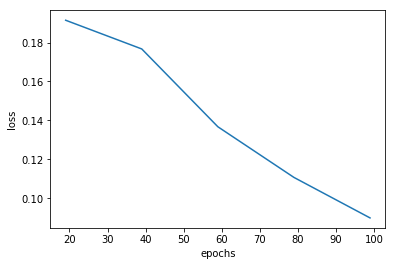

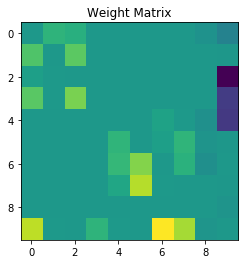

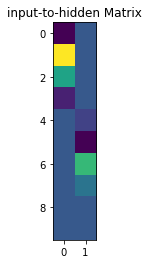

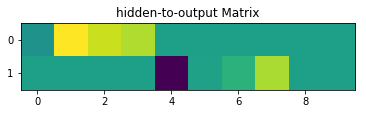

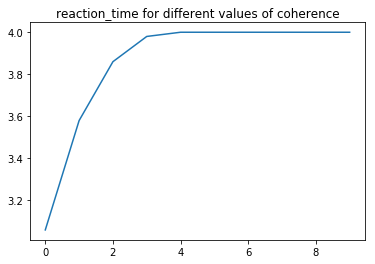

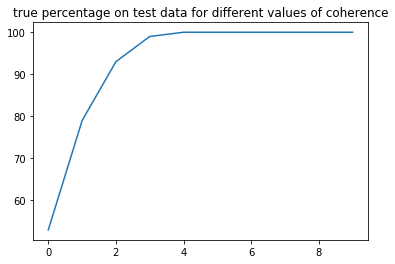

In [727]:
pdm_task3 (learning_rate=0.05, hidden_size=10, batch_size=50, number_of_epochs=100, sequence_length=20, dataset_size = 100)

# Task 2 : Parametric Working Memory

## Task 1 : Dataset

In [604]:
def frequency_dataset(DC_value1, DC_value2, Noise_amplitude, N, DC_val_opt):
    X = torch.zeros(N,25)
    output = torch.zeros(N,2)
    if DC_val_opt == 1:
        for i in range (N):
            X[i,5:10] = DC_value1
            k = np.random.randint(3,8)
            X[i,10+k:15+k] = DC_value2
            if (DC_value2 > DC_value1):
                output[i,1] = 1
            else:
                output[i,0] = 1
    else:
        for i in range(N):
            a1 = np.random.randint(1,10)
            a2 = np.random.randint(1,10)
            if (a1==a2):
                a1=a1+1
            X[i,5:10] = a1
            k = np.random.randint(3,8)
            X[i,10+k:15+k] = a2
            if (a2 > a1):
                output[i,1] = 1
            else:
                output[i,0] = 1       
    X = X + Noise_amplitude*(torch.rand(N,25)-0.5)
    return X, output

## Task 2 : Dataset Check

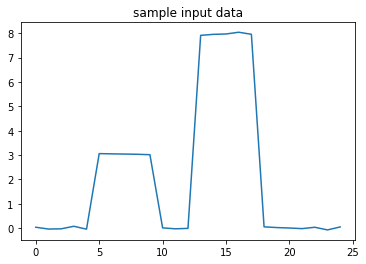

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.]])


In [607]:
X, output = frequency_dataset(DC_value1=2, DC_value2=2.2, Noise_amplitude=0.2, N=10, DC_val_opt=0)
plt.figure
plt.plot(X[0,:].numpy())
plt.title('sample input data')
plt.show()
print(output)

## Task 2 : Implementation

In [634]:
def predictor(output,N):
    out = torch.zeros(N,2)
    for i in range(N):
        if (output[i,0]>output[i,1]):
            out[i,0] = 1
            out[i,1] = 0
        else:
            out[i,0] = 0
            out[i,1] = 1
    return out
    
    return (output>0.5).double()

def frequency_task (learning_rate, hidden_size, batch_size, number_of_epochs, dataset_size = 100):

    rnn = RNN(input_size=1, hidden_size=hidden_size, output_size=2)
        
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
#     input, target = parity_generator(N,L)
    input, target = frequency_dataset(DC_value1=2, DC_value2=3, Noise_amplitude=0.2, N=N, DC_val_opt=0)
    
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        #optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((N, 2)))

        for i in range (N):
            hidden = rnn.init_hidden()
            
            for j in range (25):
                output, hidden = rnn.forward(input[i,j].unsqueeze(0), hidden)
#             print(output.size())
#             print(target[:,i].unsqueeze(0).size())
            loss = criterion(output.float(), target[i,:].unsqueeze(0))
            if(epochs == number_of_epochs-1):
                OUT[i,:] = output;
#                 print(output.data.numpy())
            loss.backward()
            if (N%batch_size==0):
                optimizer.step()
                
                for j in range (hidden_size):
                    list(rnn.hidden2hidden.parameters())[0].data[j, j].data.copy_(torch.tensor(0))
                    for i in range (hidden_size):
                        sign = 1
                        if j >= hidden_size * 4 / 5:
                            sign = -1
                        if (list(rnn.hidden2hidden.parameters())[0].data[i, j].item() * sign < 0):
                            list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))

                
                rnn.zero_grad()        
        
        if (epochs%20==19):
            print('epoch=',epochs+1, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()
    
    plt.figure
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

    s = (rnn.hidden2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('Weight Matrix')    
    plt.show()
    
    s = (rnn.input2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('input-to-hidden Matrix')    
    plt.show()
    
    s = (rnn.hidden2output.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('hidden-to-output Matrix')    
    plt.show()

    
    print('true percentage on train set = ',100*torch.sum(predictor(OUT,N)[:,0]==target[:,0]).item()/N)

    number_of_tests = 100
    
    true_percentage = np.zeros(20)
    for k in range (20):
        delta = (k+1)*0.5
        
        test_input, test_target = frequency_dataset(DC_value1=2, DC_value2=2+delta, Noise_amplitude=0.2, N = number_of_tests, DC_val_opt=1)

        test_OUT = torch.tensor(np.zeros((number_of_tests,2)))

        hidden = rnn.init_hidden()
        for test in range (number_of_tests):
            hidden = rnn.init_hidden()
            for i in range (25):
                rnn.zero_grad()
                output, hidden = rnn(test_input[test,i].unsqueeze(0), hidden)

            test_OUT[test,:] = output
            
        true_percentage[k] = 100*torch.sum(predictor(test_OUT,number_of_tests)[:,0]==test_target[:,0]).item()/number_of_tests

        print('true percentage on test set for delta = ',delta,' is ',true_percentage[k])
    delta = np.linspace(0.5,10,num=20)
    plt.figure
    plt.plot(delta, true_percentage)
    plt.title('true percentage on test data for different amounts of difference between frequency values')
    return


epoch= 20 , loss= 0.14067505300045013
epoch= 40 , loss= 0.14980070292949677
epoch= 60 , loss= 0.13817237317562103
epoch= 80 , loss= 0.14043398201465607
epoch= 100 , loss= 0.14318853616714478
epoch= 120 , loss= 0.14190468192100525
epoch= 140 , loss= 0.13117565214633942
epoch= 160 , loss= 0.1261122226715088
epoch= 180 , loss= 0.11016646027565002
epoch= 200 , loss= 0.11917907744646072


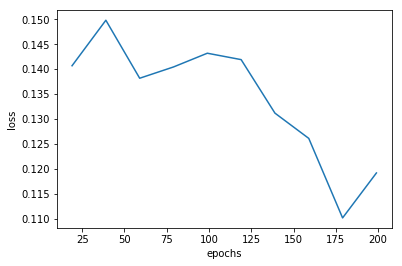

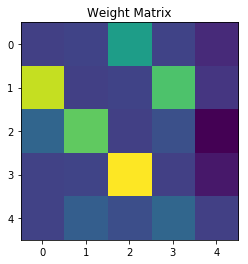

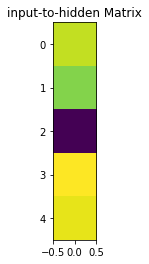

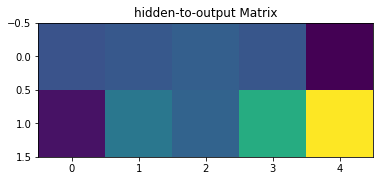

true percentage on train set =  83.0
true percentage on test set for delta =  0.5  is  0.0
true percentage on test set for delta =  1.0  is  0.0
true percentage on test set for delta =  1.5  is  0.0
true percentage on test set for delta =  2.0  is  0.0
true percentage on test set for delta =  2.5  is  0.0
true percentage on test set for delta =  3.0  is  1.0
true percentage on test set for delta =  3.5  is  18.0
true percentage on test set for delta =  4.0  is  61.0
true percentage on test set for delta =  4.5  is  94.0
true percentage on test set for delta =  5.0  is  100.0
true percentage on test set for delta =  5.5  is  100.0
true percentage on test set for delta =  6.0  is  100.0
true percentage on test set for delta =  6.5  is  100.0
true percentage on test set for delta =  7.0  is  100.0
true percentage on test set for delta =  7.5  is  100.0
true percentage on test set for delta =  8.0  is  100.0
true percentage on test set for delta =  8.5  is  100.0
true percentage on test se

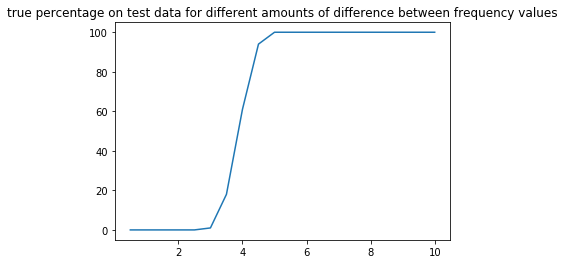

In [642]:
frequency_task (learning_rate=0.05, hidden_size=5, batch_size=20, number_of_epochs=200, dataset_size = 100)

# Task 3 : Eye-Movement Sequence Execution Task

## Task 3 : Dataset

In [534]:
def eye_movement(seq_num, partial_seq_len, test_without_marker=0):
    L = partial_seq_len*5
    X = torch.zeros(17, L)
    out = torch.zeros(2, L)
    X[4,partial_seq_len:2*partial_seq_len] = 1    
    if (seq_num == 1):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[5,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[1,4*partial_seq_len:5*partial_seq_len] = 1
        X[0,4*partial_seq_len:5*partial_seq_len] = 1
        X[2,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[9,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = 1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = -1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = 1
        out[1,4*partial_seq_len:5*partial_seq_len] = 1

    if (seq_num == 2):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[3,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[1,4*partial_seq_len:5*partial_seq_len] = 1
        X[0,4*partial_seq_len:5*partial_seq_len] = 1
        X[2,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[10,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = -1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = 1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = 1
        out[1,4*partial_seq_len:5*partial_seq_len] = 1

    if (seq_num == 3):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[3,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[6,4*partial_seq_len:5*partial_seq_len] = 1
        X[7,4*partial_seq_len:5*partial_seq_len] = 1
        X[8,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[11,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = -1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = 1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = -1
        out[1,4*partial_seq_len:5*partial_seq_len] = -1


    if (seq_num == 4):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[5,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[6,4*partial_seq_len:5*partial_seq_len] = 1
        X[7,4*partial_seq_len:5*partial_seq_len] = 1
        X[8,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[12,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = 1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = -1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = -1
        out[1,4*partial_seq_len:5*partial_seq_len] = -1


    if (seq_num == 5):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[5,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[1,4*partial_seq_len:5*partial_seq_len] = 1
        X[0,4*partial_seq_len:5*partial_seq_len] = 1
        X[2,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[13,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = 1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = 1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = 1
        out[1,4*partial_seq_len:5*partial_seq_len] = 1


    if (seq_num == 6):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[3,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[1,4*partial_seq_len:5*partial_seq_len] = 1
        X[0,4*partial_seq_len:5*partial_seq_len] = 1
        X[2,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[14,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = -1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = -1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = 1
        out[1,4*partial_seq_len:5*partial_seq_len] = 1


    if (seq_num == 7):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[3,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[6,4*partial_seq_len:5*partial_seq_len] = 1
        X[7,4*partial_seq_len:5*partial_seq_len] = 1
        X[8,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[15,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = -1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = -1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = -1
        out[1,4*partial_seq_len:5*partial_seq_len] = -1


    if (seq_num == 8):
        X[4,2*partial_seq_len:3*partial_seq_len] = 1
        X[5,2*partial_seq_len:3*partial_seq_len] = 1
        X[3,2*partial_seq_len:3*partial_seq_len] = 1
        
        X[5,3*partial_seq_len:4*partial_seq_len] = 1
        X[1,3*partial_seq_len:4*partial_seq_len] = 1
        X[7,3*partial_seq_len:4*partial_seq_len] = 1
        
        X[6,4*partial_seq_len:5*partial_seq_len] = 1
        X[7,4*partial_seq_len:5*partial_seq_len] = 1
        X[8,4*partial_seq_len:5*partial_seq_len] = 1
        
        X[16,:] = 1
        
        out[0,2*partial_seq_len:3*partial_seq_len] = 1
        out[0,3*partial_seq_len:4*partial_seq_len] = 0
        out[0,4*partial_seq_len:5*partial_seq_len] = 1
        
        out[1,2*partial_seq_len:3*partial_seq_len] = 0
        out[1,3*partial_seq_len:4*partial_seq_len] = -1
        out[1,4*partial_seq_len:5*partial_seq_len] = -1
    
    if (test_without_marker==1):
        X[9:,:] = 0

    return X, out
    
    
        
        
        
        
    

## Task 3 : Dataset Check

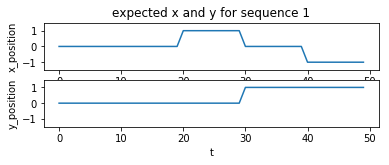

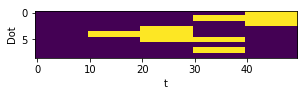

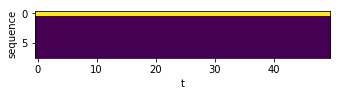

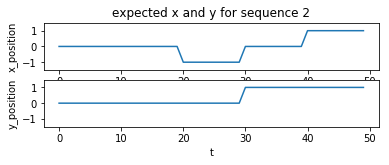

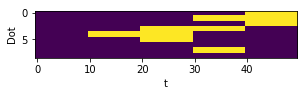

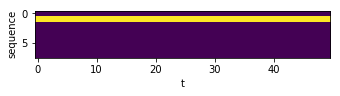

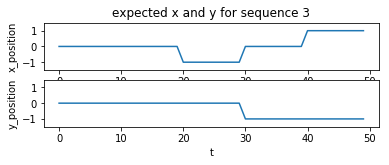

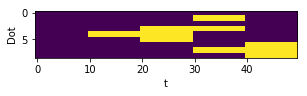

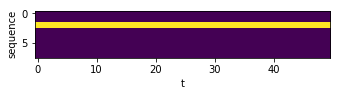

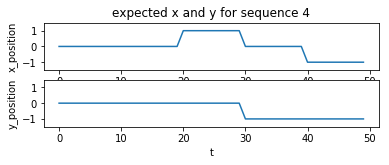

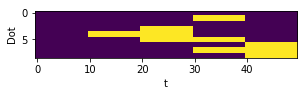

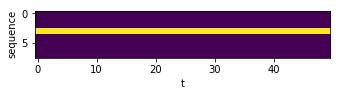

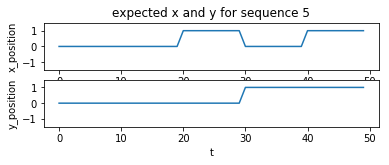

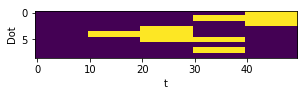

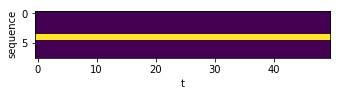

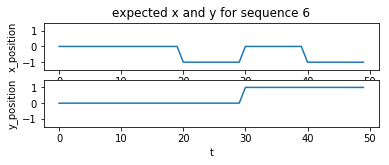

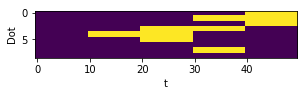

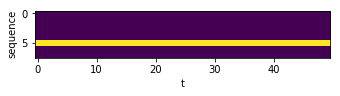

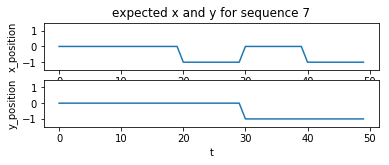

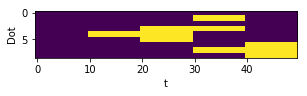

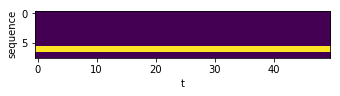

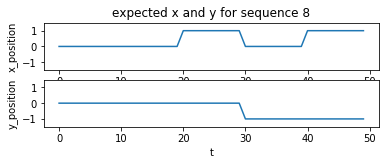

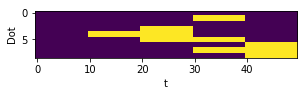

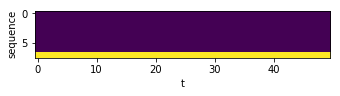

In [483]:

for seq_num in range (1, 9):
    
    input, output = eye_movement(seq_num = seq_num, partial_seq_len = 10)
    plt.figure
    plt.subplot(4,1,1)
    plt.plot(output[0,:].numpy())
    plt.ylim([-1.5,1.5])
    plt.xlabel('t')
    plt.ylabel('x_position')
    plt.title('expected x and y for sequence ' + str(seq_num))

    plt.subplot(4,1,2)
    plt.plot(output[1,:].numpy())
    plt.ylim([-1.5,1.5])
    plt.xlabel('t')
    plt.ylabel('y_position')
    plt.show()
    
    plt.subplot(4,1,3)
    plt.figure
    plt.imshow(input[0:9,:].numpy())
    plt.xlabel('t')
    plt.ylabel('Dot')
    plt.show()
    
    plt.subplot(4,1,3)
    plt.figure
    plt.imshow(input[9:,:].numpy())
    plt.xlabel('t')
    plt.ylabel('sequence')
    plt.show()


## Task 3 : Implementation

In [487]:
def eye_movement_nn (learning_rate, hidden_size, batch_size, number_of_epochs, sequence_length=10, dataset_size = 100, test_without_marker = 0):

    rnn = RNN(input_size=17, hidden_size=hidden_size, output_size=2)
    
    L = int(sequence_length/5)
    
    N = dataset_size
    
    num_of_batches = int(N/batch_size)
    
    
    #input, target = eye_movement(seq_num, L)
        
    epochs_samples = np.zeros(int(number_of_epochs/20))
    
    epoch_loss = np.zeros(int(number_of_epochs/20))


    for epochs in range(number_of_epochs):
        criterion = nn.MSELoss()

        learning_rate = 0.005

        #optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

        OUT = torch.tensor(np.zeros((2, sequence_length)))

        for i in range (N):
            hidden = rnn.init_hidden()
            input, target = eye_movement(seq_num = 1 + i%8, partial_seq_len = L)
            for j in range (sequence_length):
                output, hidden = rnn.forward(input[:,j], hidden)
                loss = criterion(output.float(), target[:,j].unsqueeze(0))
            
                if(epochs == number_of_epochs-1):
                    OUT[:,j] = output;
                loss.backward(retain_graph=True)
            if (N%batch_size==0):
                optimizer.step()
                
                for j in range (hidden_size):
                    list(rnn.hidden2hidden.parameters())[0].data[j, j].data.copy_(torch.tensor(0))
                    for i in range (hidden_size):
                        sign = 1
                        if j >= hidden_size * 4 / 5:
                            sign = -1
                        if (list(rnn.hidden2hidden.parameters())[0].data[i, j].item() * sign < 0):
                            list(rnn.hidden2hidden.parameters())[0].data[i, j].data.copy_(torch.tensor(0))

                
                rnn.zero_grad()        
        
        if (epochs%20==19):
            print('epoch=',epochs+1, ', loss=', loss.item())
            number = int(epochs/20)
            epochs_samples[number] = epochs
            epoch_loss[number] = loss.item()
            
    plt.figure
    plt.plot(epochs_samples, epoch_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
            
    plt.figure
    plt.subplot(2,1,1)
    plt.plot(OUT[0,:].detach().numpy(),label='output')
    plt.plot(target[0,:].detach().numpy(),label='target')
    plt.ylim([-1.5,1.5])
    plt.xlabel('t')
    plt.ylabel('x_position')
    plt.legend()
    plt.title('a sample result on train set')

    plt.subplot(2,1,2)
    plt.plot(OUT[1,:].detach().numpy(),label='output')
    plt.plot(target[1,:].detach().numpy(),label='target')
    plt.ylim([-1.5,1.5])
    plt.xlabel('t')
    plt.ylabel('y_position')
    plt.legend()
    plt.show()
    
    s = (rnn.hidden2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('Weight Matrix')    
    plt.show()
    
    s = (rnn.input2hidden.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('input-to-hidden Matrix')    
    plt.show()
    
    s = (rnn.hidden2output.weight.data)
    plt.figure()
    plt.imshow(s)
    plt.title('hidden-to-output Matrix')    
    plt.show()

    number_of_tests = 8
    
    for i in range(number_of_tests):
        test_input, test_target = eye_movement(seq_num = 1 + i, partial_seq_len = L, test_without_marker = test_without_marker)
        test_OUT = torch.tensor(np.zeros((2, sequence_length)))
#     test_input, test_target = decision_making_dataset(DC_value1=1, DC_value2=1.5, Input_size=L, Noise_amplitude=1, N = number_of_tests, DC_val_opt=1)
        hidden = rnn.init_hidden()
        for j in range (sequence_length):
            output, hidden = rnn.forward(test_input[:,j], hidden)
            test_OUT[:,j] = output
                
        plt.figure
        plt.subplot(2,1,1)
        plt.plot(test_OUT[0,:].detach().numpy(),label='output')
        plt.plot(test_target[0,:].detach().numpy(),label='target')
        plt.ylim([-1.5,1.5])
        plt.xlabel('t')
        plt.ylabel('x_position')
        plt.legend()
        plt.title('test result on sequence ' + str(i+1))

        plt.subplot(2,1,2)
        plt.plot(test_OUT[1,:].detach().numpy(),label='output')
        plt.plot(test_target[1,:].detach().numpy(),label='target')
        plt.ylim([-1.5,1.5])
        plt.xlabel('t')
        plt.ylabel('y_position')
        plt.legend()
        plt.show()

        
    return


## Task 3 : Check on small hidden sized network with full input

epoch= 20 , loss= 0.9966835379600525
epoch= 40 , loss= 0.9114185571670532
epoch= 60 , loss= 0.8924885392189026
epoch= 80 , loss= 0.8689046502113342
epoch= 100 , loss= 0.8786497712135315


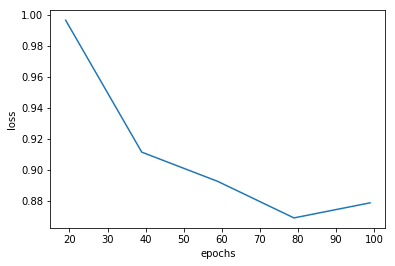

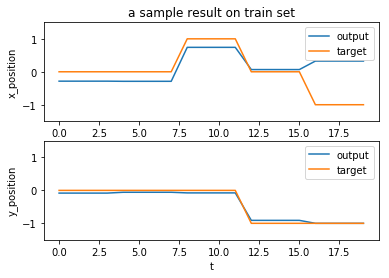

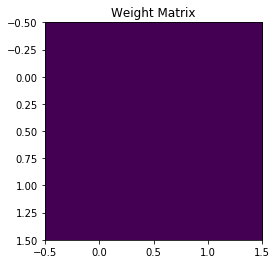

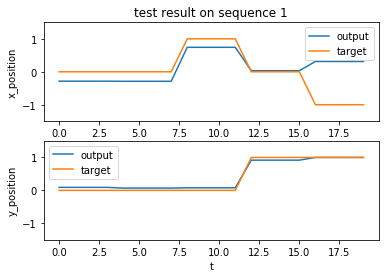

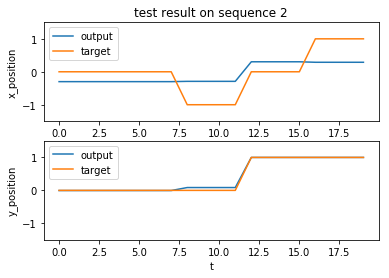

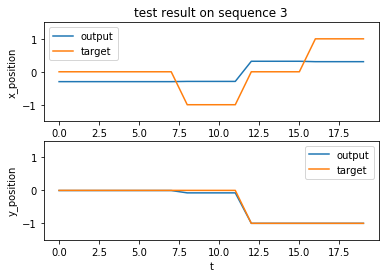

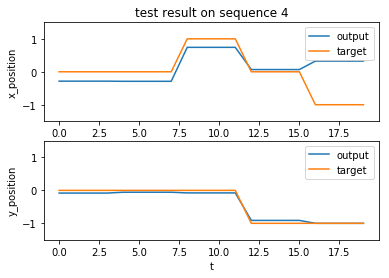

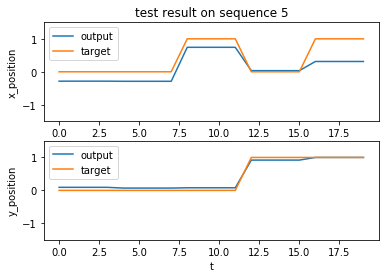

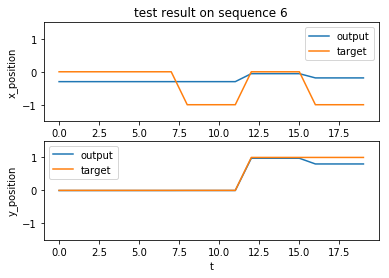

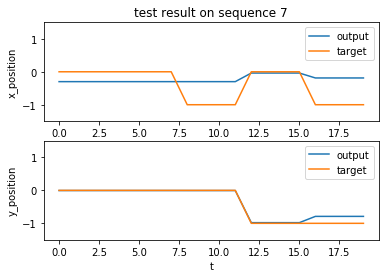

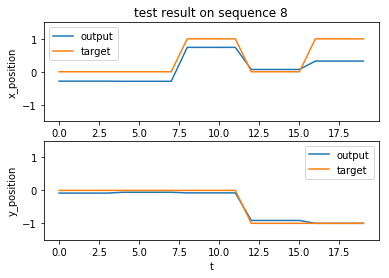

In [485]:
eye_movement_nn(learning_rate=0.05, hidden_size=2, batch_size=10, number_of_epochs=100, sequence_length=20, dataset_size = 100, test_without_marker = 0)

## Task 3 : Check on larger hidden sized network with full input

epoch= 20 , loss= 0.013836509548127651
epoch= 40 , loss= 0.0007038204348646104
epoch= 60 , loss= 0.0005039993557147682
epoch= 80 , loss= 0.0003746270958799869
epoch= 100 , loss= 0.00028760122950188816


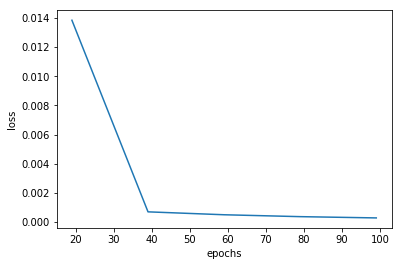

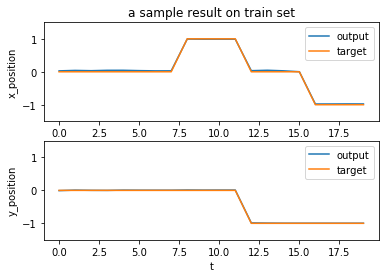

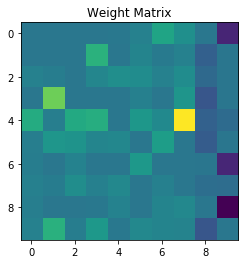

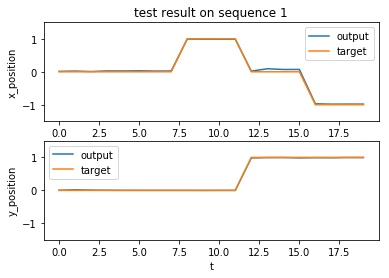

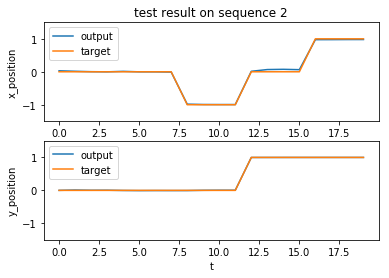

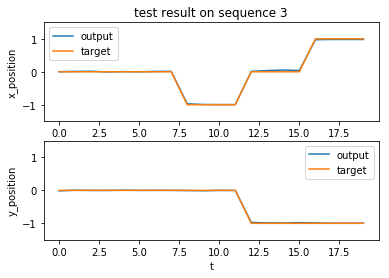

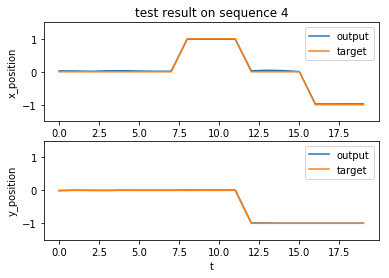

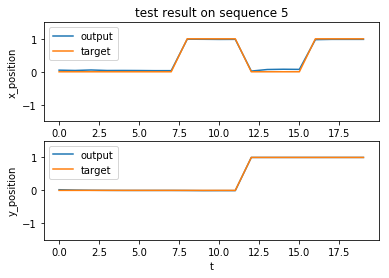

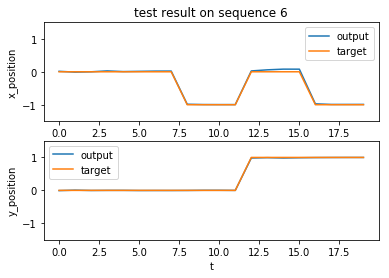

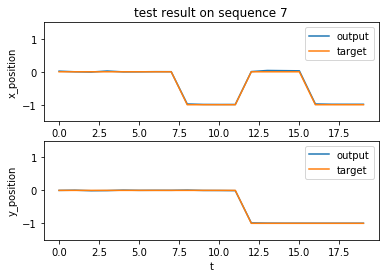

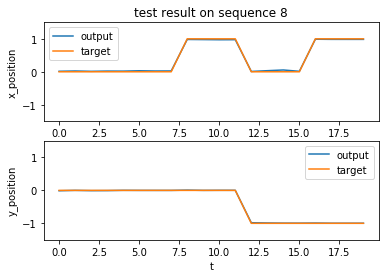

In [486]:
eye_movement_nn(learning_rate=0.05, hidden_size=10, batch_size=10, number_of_epochs=100, sequence_length=20, dataset_size = 100, test_without_marker = 0)

## Task 3 : Check on network with non-full input

epoch= 20 , loss= 0.0004352860269136727
epoch= 40 , loss= 7.373536936938763e-05
epoch= 60 , loss= 8.236335997935385e-05
epoch= 80 , loss= 6.154659058665857e-05
epoch= 100 , loss= 5.6308344937860966e-05


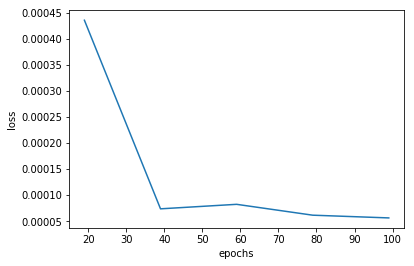

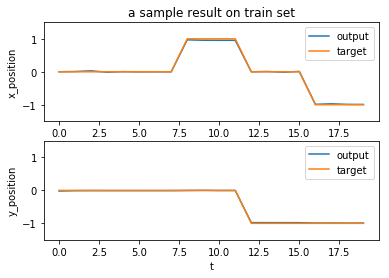

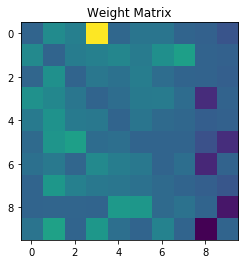

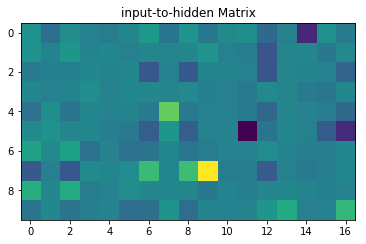

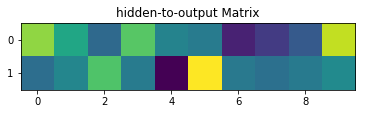

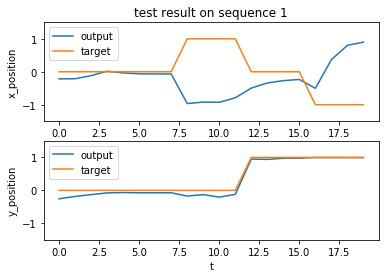

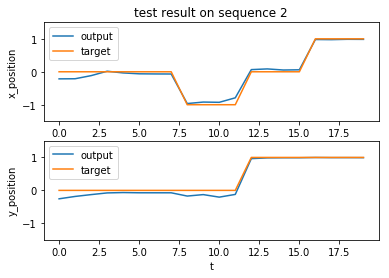

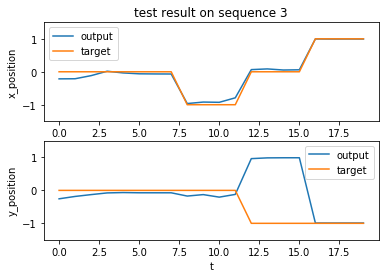

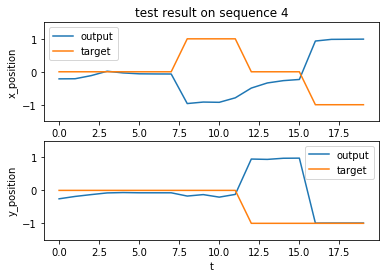

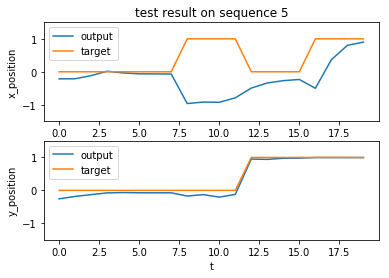

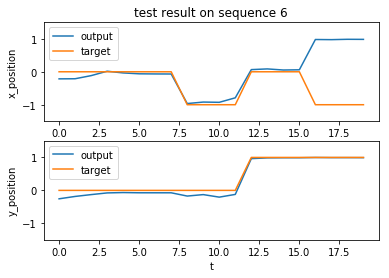

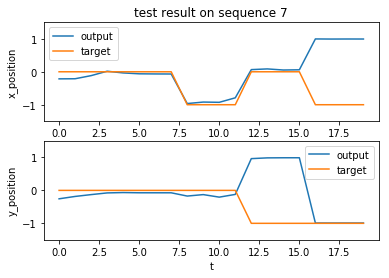

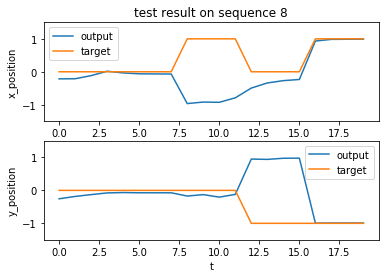

In [488]:
eye_movement_nn(learning_rate=0.05, hidden_size=10, batch_size=10, number_of_epochs=100, sequence_length=20, dataset_size = 100, test_without_marker = 1)